Importamos las librerias necesarias y los datos a utilizar 

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

In [2]:
datos = pd.read_csv("sign_mnist_train.csv")

Analisis exploratorio de Datos :

In [3]:
datos.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


1a. ¿Cuáles parecen ser atributos relevantes para predecir la letra a la que
corresponde la seña? ¿Cuáles no? ¿Creen que se pueden descartar
atributos?



Para analizar la importancia de los datos, vamos a reducirlos a tres dimensiones utilizando PCA. Luego, observaremos los coeficientes que definen
$Z_1,Z_2,Z_3$ y tendremos una métrica de importancia de atributos relevantes basada en la varianza.

In [4]:
pca = PCA(n_components=3)

# Assuming datos is your DataFrame
letras = datos.iloc[:, 0].values
X = datos.iloc[:, 1:].values

# Normalizamos los datos 
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# PCA con 3 componentes
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_normalized)

# Creamos el DataFrame con los datos en tres dimensiones y los labels de las letras
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pc_df = pd.concat([pd.DataFrame(letras, columns=['Letra']), pc_df], axis=1)


Graficamos las componentes principales(sampleando pocas muestras) para poder visualizar la varianza de nuestros datos.

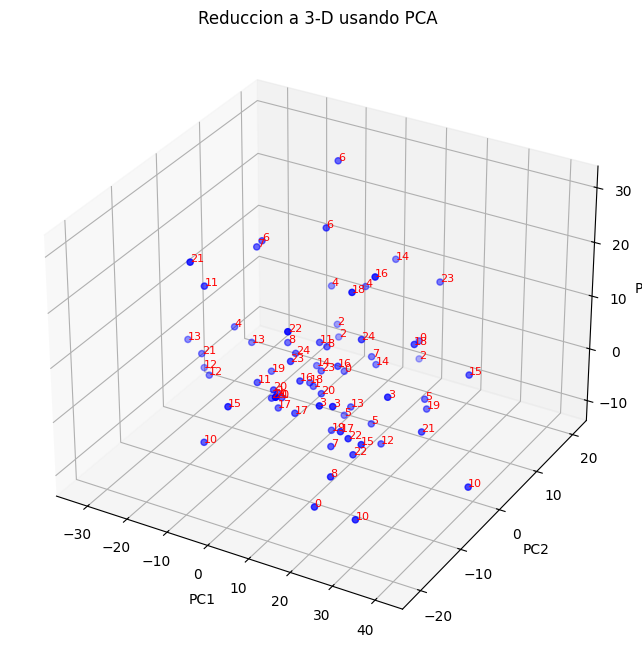

In [5]:
# Funcion que toma una muestra de 3 instancias de cada letra
def sample_rows(group):
    return group.sample(n=min(3, len(group)), replace=False)

# Aplicamos la funcion a cada letra
sample = pc_df.groupby('Letra', group_keys=False).apply(sample_rows)

# Ploteamos
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample['PC1'], sample['PC2'], sample['PC3'], c='blue', marker='o')

#Nombres
for i, txt in enumerate(sample['Letra']):
    ax.text(sample['PC1'].iloc[i], sample['PC2'].iloc[i], sample['PC3'].iloc[i],txt, size=8, color='red')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Reduccion a 3-D usando PCA')
plt.show()

Para definir cual de los 784 atributos de nuestros datos son los tres mas relevantes, tomaremos un 1 $\leq$ i_m $\leq$
 784 tal que: $\begin{equation} 
\phi_{i_m} = \max\limits_{{1 \leq j \leq 784}}\phi_{mj} \end{equation} $ para todo 1 $\leq$ m $\leq$ M, en este caso particular tomamos M=3.
 La elección de atributos se basa en el hecho que los $\phi_{ij}$ son hallados de forma tal que maximicen la varianza de $Z_m$ y en que las PC's sean ortogonales, por lo que los $i_m$ qque tomamos representan el elemento más significativo de cada una de los tres elementos de la base que define el espacio de dimensión M (en este caso 3) en el que plasmamos los datos.  Este criterio nos otorgara 3 atributos $X_{i_1}$,$X_{i_2}$,$X_{i_3}$. Veamos cuales son

In [6]:
#Accedemos a las constantes phi
loadings = pca.components_
#loadings[i, j] nos retorna el valor de phi para el j-esimo atributo del dataset y la i-esima componente principal (PC_i)

#Buscamos el atributo con el valor de phi mas alto para cada uno de nuestros componentes principales
for i in range(3):
    phi_i = loadings[i]
    max = np.argmax(phi_i)
    #Le sumamos uno a max porque la primera columna indica la letra, luego viene el X que usamos para reducir dimensiones
    print(f"El atributo mas significativo en PC{i+1} es {datos.columns[max+1]}")


El atributo mas significativo en PC1 es pixel784
El atributo mas significativo en PC2 es pixel505
El atributo mas significativo en PC3 es pixel263


En conclusión, según el criterio con M = 3, los atributos más importantes son los píxeles 784, 263 y 505. Si quisiéramos eliminar una cantidad de atributos, digamos n, bastaría con tomar M = 784 - n y repetir el proceso anterior.

Al mirar las imágenes, aparentan haber varios píxeles que varían poco o nada de letra a letra. Para buscarlos, uno podría fijarse cuáles son los valores de j donde $\phi_{ij}$ que tienen un valor muy bajo $\forall 1\leq i \leq M$. La dificultad yace en elegir el hiperparámetro M, ya que la operación es computacionalmente cara y tiene 784 posibles valores

1b. Resulta mas facil diferenciar la 'E' y la 'M', o la 'L' y la 'M'?

Vamos a formar dos datasets, uno formado por las instancias de 'E' y 'M', otro formado por las instancias de 'L' y 'M'. 

In [7]:
#Visualizemos un primer ejemplo 
L = 11
M = 12
E = 4
#Vamos a formar dos datasets, uno formado por las instancias de 'E' y 'M', otro formado
#por las instancias de 'L' y 'M'

datosLyE =  datos[(datos['label'] == L) | (datos['label'] == E)]

datosLyM =  datos[(datos['label'] == L) | (datos['label'] == M)]


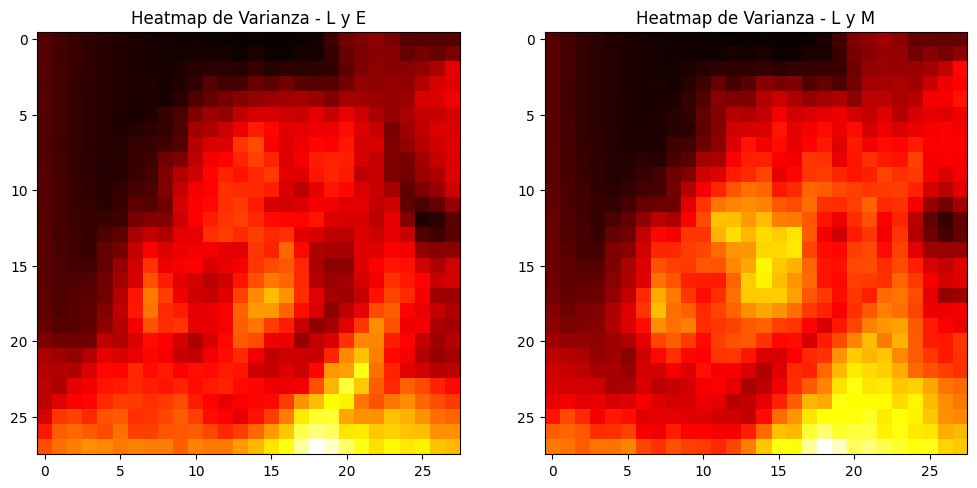

In [8]:

# Para cada pixel de la matrix de greyscale, calculamos la varianza del mismo
def matrixVarianza(data):
    map_dirty = [[[] for _ in range(28)] for _ in range(28)]
    var_map = [[0 for _ in range(28)] for _ in range(28)]

    for row in data.values:
        mat = row[1:].reshape(28, 28)
        for i in range(28):
            for j in range(28):
                map_dirty[i][j].append(mat[i][j])
    for i in range(28):
        for j in range(28):
            var_map[i][j] = np.var(map_dirty[i][j])
    return var_map

# Matriz de varianza de los datosLyE y datosLyM
varLyE = matrixVarianza(datosLyE)
varLyM = matrixVarianza(datosLyM)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot para datosLyE
axs[0].imshow(varLyE, cmap='hot', interpolation='nearest')
axs[0].set_title('Heatmap de Varianza - L y E')

# Plot for datosLyM
axs[1].imshow(varLyM, cmap='hot', interpolation='nearest')
axs[1].set_title('Heatmap de Varianza - L y M')

# Show the combined plot
plt.show()

Los gráficos realizados son heatmaps de la varianza de cada píxel a lo largo de dos bases de datos, una que contiene L y E, y una segunda que contiene L y M. En base a estos gráficos, podemos conjeturar que resulta más fácil distinguir una L de una E que distinguir una L de una M, pues cerca del centro podemos ver que la varianza entre una L y una E es superior a la varianza de una L y una M.
P.D. Los heatmaps utilizados son equivalentes a gráficos de barra. Decidimos no usar estos últimos dado que tendrían 784 barras, lo cual dificultaría la lectura de la visualización.

Podemos usar PCA para verificar estos resultados

In [8]:
#PCA para L y M
pcaLyM = PCA(n_components=3)

letras = datosLyM.iloc[:, 0].values
XLyM = datosLyM.iloc[:, 1:].values

# Normalizamos los datos 
scaler = StandardScaler()
XLyM_normalized = scaler.fit_transform(XLyM)

# PCA con 3 componentes
pcaLyM = PCA(n_components=3)
PCLyM = pcaLyM.fit_transform(XLyM_normalized)

# Creamos el DataFrame con los datos en tres dimensiones y los labels de las letras
pcLyM_df = pd.DataFrame(data=PCLyM, columns=['PC1', 'PC2', 'PC3'])
pcLyM_df = pd.concat([pd.DataFrame(letras, columns=['Letra']), pcLyM_df], axis=1)



#PCA para L y E
pcaLyE = PCA(n_components=3)

letras = datosLyE.iloc[:, 0].values
XLyE = datosLyE.iloc[:, 1:].values

# Normalizamos los datos 
scaler = StandardScaler()
XLyE_normalized = scaler.fit_transform(XLyE)

# PCA con 3 componentes
pcaLyE = PCA(n_components=3)
PCLyE = pcaLyE.fit_transform(XLyE_normalized)

# Creamos el DataFrame con los datos en tres dimensiones y los labels de las letras
pcLyE_df = pd.DataFrame(data=PCLyE, columns=['PC1', 'PC2', 'PC3'])
pcLyE_df = pd.concat([pd.DataFrame(letras, columns=['Letra']), pcLyE_df], axis=1)




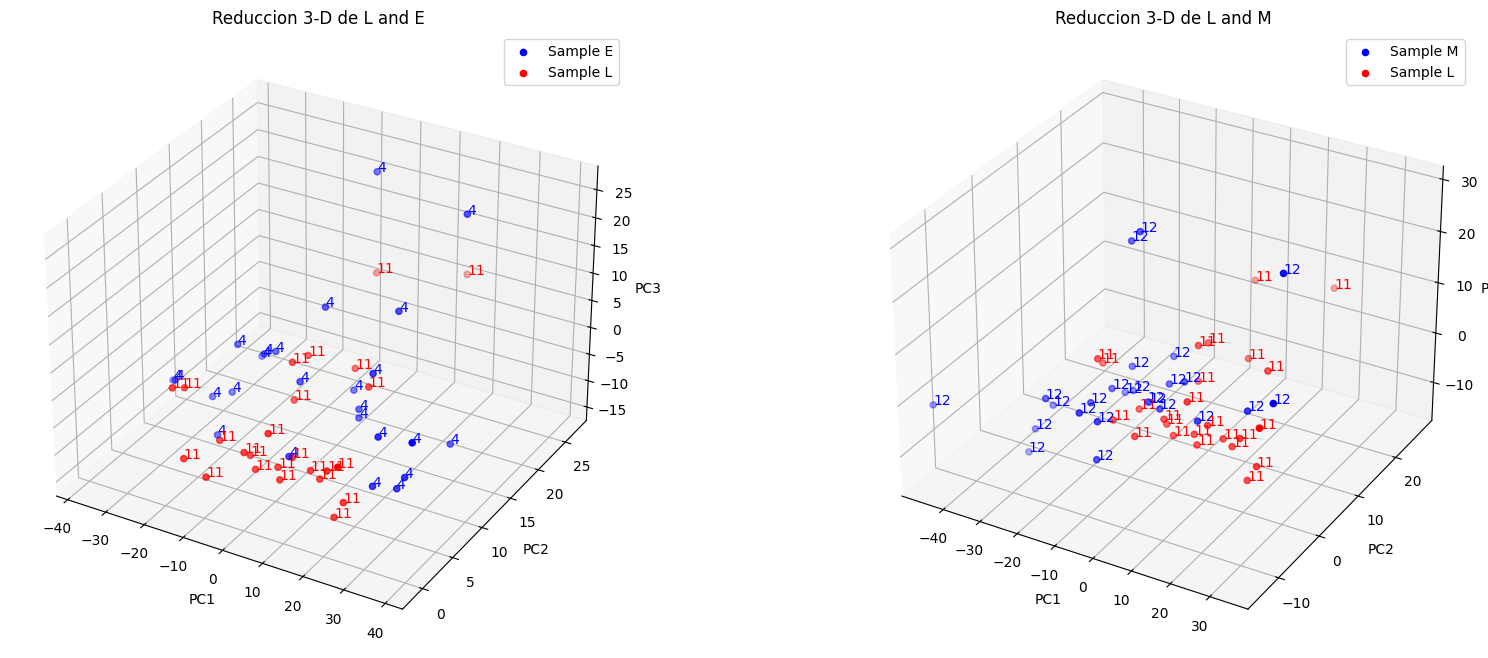

In [9]:
# Funcion que toma una muestra de 3 instancias de cada letra
def sample_rows(group):
    return group.sample(n=min(25, len(group)), replace=False)


# Aplicamos la funcion a cada letra
sampleLyM = pcLyM_df.groupby('Letra', group_keys=False).apply(sample_rows)

sampleM = sampleLyM[sampleLyM['Letra'] == 12]

sampleL = sampleLyM[sampleLyM['Letra'] == 11]

# Aplicamos la funcion a cada letra
sampleLyE = pcLyE_df.groupby('Letra', group_keys=False).apply(sample_rows)

sampleE = sampleLyE[sampleLyE['Letra'] == 4]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': '3d'})

# Ploteos de sampleE y sampleL
ax1.scatter(sampleE['PC1'], sampleE['PC2'], sampleE['PC3'], c='blue', marker='o', label='Sample E')
ax1.scatter(sampleL['PC1'], sampleL['PC2'], sampleL['PC3'], c='red', marker='o', label='Sample L')

for (x, y, z, label) in zip(sampleE['PC1'], sampleE['PC2'], sampleE['PC3'], sampleE['Letra']):
    ax1.text(x, y, z, label, color='blue')

for (x, y, z, label) in zip(sampleL['PC1'], sampleL['PC2'], sampleL['PC3'], sampleL['Letra']):
    ax1.text(x, y, z, label, color='red')

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('Reduccion 3-D de L and E')
ax1.legend()


ax2.scatter(sampleM['PC1'], sampleM['PC2'], sampleM['PC3'], c='blue', marker='o', label='Sample M')
ax2.scatter(sampleL['PC1'], sampleL['PC2'], sampleL['PC3'], c='red', marker='o', label='Sample L')

for (x, y, z, label) in zip(sampleM['PC1'], sampleM['PC2'], sampleM['PC3'], sampleM['Letra']):
    ax2.text(x, y, z, label, color='blue')

for (x, y, z, label) in zip(sampleL['PC1'], sampleL['PC2'], sampleL['PC3'], sampleL['Letra']):
    ax2.text(x, y, z, label, color='red')

ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.set_title('Reduccion 3-D de L and M')
ax2.legend()


plt.show()

1c. Tomen una de las clases, por ejemplo la seña correspondiente a la C,
¿Son todas las imágenes muy similares entre sí?

Una forma simple pero informal de evaluar la similitud es tomando imágenes aleatorias de la letra C. Veamos qué resultados nos da

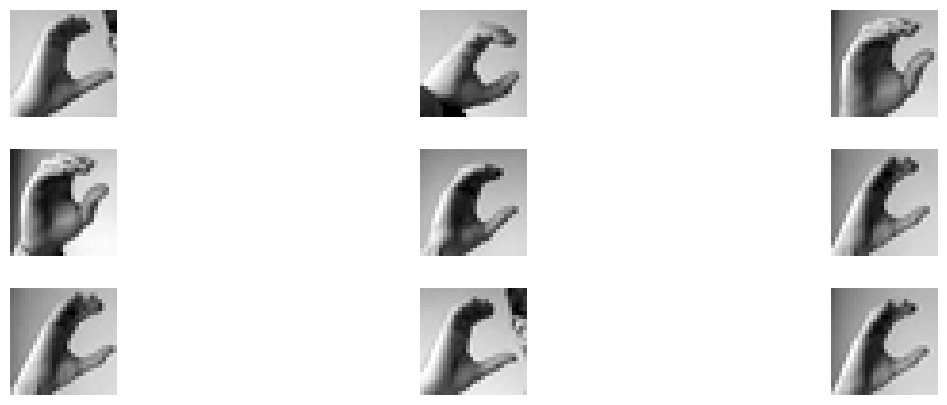

In [9]:
np.random.seed(457)

def randomLetras(n):
    listaTablaLetrasC = datos[datos['label'] == 2]

    # Numero de filas y columnas
    num_rows = int(np.ceil(n / 3))
    num_cols = min(3, n)

    # subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5), gridspec_kw={'hspace': 0.3})

    for i in range(num_rows):
        for j in range(num_cols):
            if i * num_cols + j < n:
                # Seleccion de imagen random
                index = random.randint(0, len(listaTablaLetrasC) - 1)
                image_data = listaTablaLetrasC.iloc[index, 1:].values.reshape(28, 28)

                # Plot the image
                axs[i, j].matshow(image_data, cmap="gray")
                axs[i, j].axis('off')  
    plt.show()

randomLetras(9)  

Uno puede ver que el pulgar y el ángulo de los dedos parecen variar de imagen a imagen, a pesar de no ser mucha diferencia a simple vista, la baja cantidad de píxeles que utilizamos puede hacer que la distinción automática resulte difícil. Para ver esto, vamos a implementar un clustering jerárquico sobre los datos de la letra C.

Reduccion a base 3

In [10]:
datosC = datos[datos['label'] == 2]
# Sacamos los labels
datosC = datosC.iloc[:, 1:].values

# Normalizamos los datos 
scaler = StandardScaler()
datosC_normalized = scaler.fit_transform(datosC)

# PCA con 3 componentes
pcaC= PCA(n_components=3)
C3D = pcaC.fit_transform(datosC_normalized)

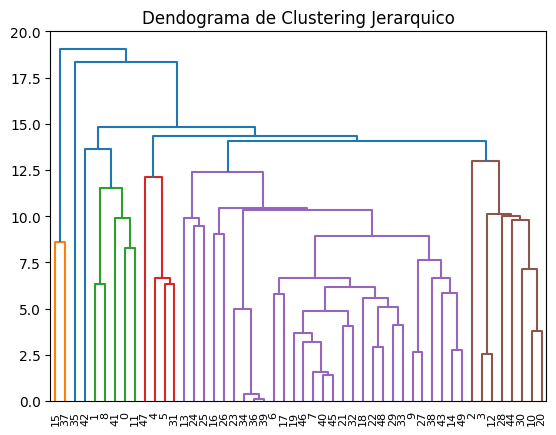

La maxima distancia entre dos datos es 79.14731510527088


In [11]:
np.random.seed(457)
num_samples = 50
random_indices = np.random.choice(C3D.shape[0], size=num_samples, replace=False)
sampleC = C3D[random_indices, :]


# Perform hierarchical clustering
Z = linkage(sampleC, method='single')  # You can choose a different linkage method

# Visualize the dendrogram (optional)
dendrogram(Z)
plt.title('Dendograma de Clustering Jerarquico')
plt.show()

# Menor cantidad posible de clusters
threshold = 1  

clusters = fcluster(Z, t=threshold, criterion='distance')

#Para poner en contexto el dendograma vamos a ver el rango de distincia entre los puntos que tomamos
distances = pdist(sampleC)

#Rango de la distancia de los puntos utilizados
print(f'La maxima distancia entre dos datos es {np.ptp(distances)}') 



En este ejemplo en particular, la máxima distancia entre dos puntos es mas de 80 y recién con epsilon mayor a 17.5 tenemos un solo cluster.


1d. La alta dimensión de los datos requiere utilizar PCA antes de cualquier visualización de varias instancias, y antes de aplicar muchos recursos típicamente usados. Una vez que está realizada la reducción de dimensión, este problema no está presente, sin embargo, para lograr este estado, se sacrifica una porción de la información original.

2a. Construimos un dataframe que contenga solamente imagenes de A y de L 


In [11]:
L = 11
A = 0
LyA =  datos[(datos['label'] == L) | (datos['label'] == A)]

2b. Vemos la proporcion de datos de L y A que tenemos en los datos. En base a la siguente tabla, podemos ver que efectivamente es una base de datos balanceada

In [12]:
count = LyA['label'].value_counts()
print(count)

label
11    1241
0     1126
Name: count, dtype: int64


2c. Separamos los datos en splits de Training y Test

In [13]:
# Holdout
LyA_temp, LyA_hold = train_test_split(LyA, test_size=0.1, random_state=457)

#Variables dependientes
X = LyA_temp.iloc[:,1:]
#Variables a predecir
y = LyA_temp['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=457)


2d. y 2e. Ajustar un modelo de KNN considerando pocos atributos, por ejemplo
3 . Probar con distintos conjuntos de 3 atributos y comparar resultados.
Analizar utilizando otras cantidades de atributos.

Comparar modelos de KNN utilizando distintos atributos y distintos
valores de k (vecinos). Para el análisis de los resultados, tener en
cuenta las medidas de evaluación (por ejemplo, la exactitud) y la
cantidad de atributos

In [14]:
#Primero vamos a generar una particion de atributos, estos son pixel1,pixel2,...pixel784

#Vamos a usar una random seed para generar agrupaciones de a 3 atributos random(pero recreables) y asi comparar  
# los modelos generado por atributos distintos 

#Tambien, por separado, vamos a tomar los pixeles mas significativos segun el criterio utilizado en 1.a

random.seed(457)

modeloLyA = KNeighborsClassifier(n_neighbors = 3) 

#Para cada cantidad de atributos vamos a realizar 3 modelos distintos seleccionando atributos al azar 
Nrep = 10
cantAtributos = [3,15,50]

#Vamos a guardar los score de los modelos aleatorios para luego comparar 
resultados_test  = np.zeros(( len(cantAtributos), Nrep ))
resultados_train = np.zeros((len(cantAtributos), Nrep ))
resultados_holdout = np.zeros((len(cantAtributos), Nrep ))
# Las filas corresponden a una cantidad de atributos(preservando el oroden del vector cantAtributos) y las columnas corresponden 
# una intancia de un modelo con atributos randomizados  

#Almacenamos los atributos que utilizamos en cada instancia 
atributosXmodelo = [[] for _ in range(len(cantAtributos))]

for n in range(len(cantAtributos)):
    for i in range(Nrep):
        pixeles = random.sample(range(0, 783), cantAtributos[n])
        atributosXmodelo.append(pixeles) 
        X_trainRand = X_train.iloc[:, pixeles]
        X_testRand =  X_test.iloc[:, pixeles]
        neighRand = KNeighborsClassifier(n_neighbors = cantAtributos[n])
        # Entrenamos el modelo (con datos de train)
        neighRand.fit(X_trainRand, y_train) 
        # Evaluamos el modelo con datos de train y luego de test
        resultados_train[n,i] = neighRand.score(X_trainRand, y_train)
        resultados_test[n,i]  = neighRand.score(X_testRand , y_test )
        




In [15]:

#Hacemos un modelo con los tres pixeles mas significativo segun el citerio empleado en el 1.a
pixelsSig = [784-1, 263-1, 505-1]
X_trainSig = X_train.iloc[:, pixelsSig]
X_testSig =  X_test.iloc[:, pixelsSig]
neighSig = KNeighborsClassifier(n_neighbors = 3)
# Entrenamos el modelo (con datos de train)
neighSig.fit(X_trainSig, y_train) 
# Evaluamos el modelo con datos de train y luego de test
resultadosSigTrain = neighSig.score(X_trainSig, y_train)
resultadosSigTest  = neighSig.score(X_testSig , y_test)

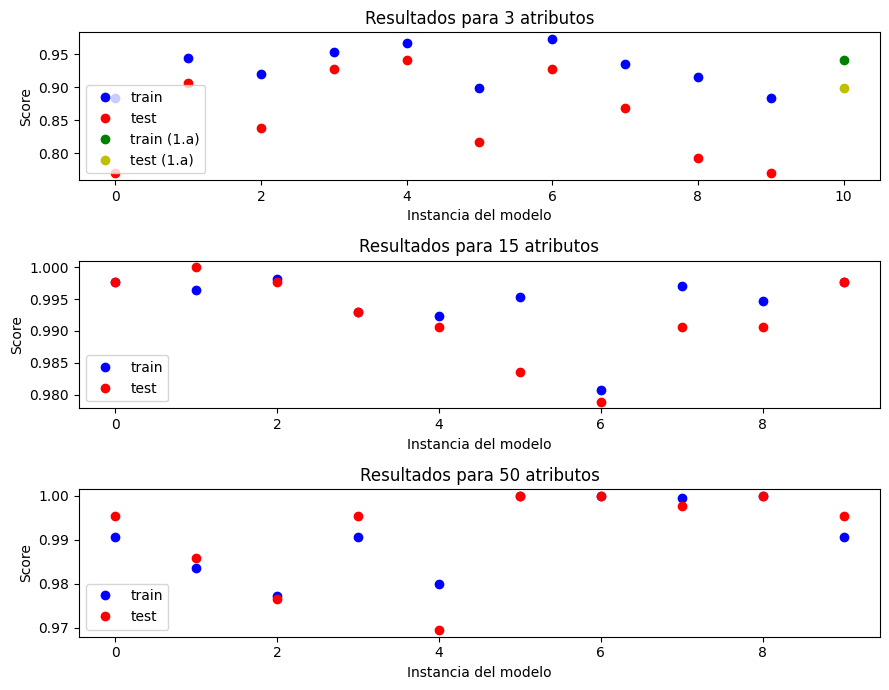

In [16]:
# creamos una figura y ejes para cada cantidad de atributos
fig, axs = plt.subplots(len(cantAtributos), 1, figsize=(9, 7))

# iteramos sobre cada cantidad de atributos
for idx, n in enumerate(cantAtributos):
    # Iterar sobre las 5 instancias de un modelo con ésa cantidad de atributos
    
    if (idx==0):
        # ploteamos los resultados de entrenamiento y prueba para cada instancia
        axs[idx].plot(0, resultados_train[idx, i], 'bo', label='train')
        axs[idx].plot(0, resultados_test[idx, i], 'ro', label='test')
        for i in range(1,Nrep):
            # ploteamos los resultados de entrenamiento y prueba para cada instancia
            axs[idx].plot(i, resultados_train[idx, i], 'bo')
            axs[idx].plot(i, resultados_test[idx, i], 'ro')
        
            # configuramos etiquetas y título para el subplot actual
            axs[idx].set_xlabel('Instancia del modelo')
            axs[idx].set_ylabel('Score')
            axs[idx].set_title(f'Resultados para {n} atributos')
            axs[idx].legend()
    
        # ploteamos la parte del ejercicio 1.a
        axs[idx].plot(Nrep, resultadosSigTrain, 'go', label='train (1.a)')
        axs[idx].plot(Nrep, resultadosSigTest, 'yo', label='test (1.a)')
        # configuramos etiquetas y título para el subplot actual
        axs[idx].set_xlabel('Instancia del modelo')
        axs[idx].set_ylabel('Score')
        axs[idx].set_title(f'Resultados para {n} atributos')
        axs[idx].legend()
    

    else:
        # ploteamos los resultados de entrenamiento y prueba para cada instancia
        axs[idx].plot(0, resultados_train[idx, i], 'bo', label='train')
        axs[idx].plot(0, resultados_test[idx, i], 'ro', label='test')
        for i in range(1,Nrep):
            # ploteamos los resultados de entrenamiento y prueba para cada instancia
            axs[idx].plot(i, resultados_train[idx, i], 'bo')
            axs[idx].plot(i, resultados_test[idx, i], 'ro')
        
            # configuramos etiquetas y título para el subplot actual
            axs[idx].set_xlabel('Instancia del modelo')
            axs[idx].set_ylabel('Score')
            axs[idx].set_title(f'Resultados para {n} atributos')
            axs[idx].legend()

# ajusto el espacio entre subplots
plt.tight_layout()

# gráfico
plt.show()

Podemos ver que elegir los píxeles con un criterio adecuado resulta mucho más útil que elegir una gran cantidad de ellos. El modelo basado en los 3 píxeles más significativos que definimos en el ítem a (punto color dorado en el primer gráfico) resultaron tener un mejor resultado que varios modelos que utilizan 50 píxeles aleatorios.

Vamos a tomar un modelo por cada cantidad de atributos y medir su error usando el metodo hold-out.

IMPORTANTE: esto depende de la random seed que fue seleccionada, la cual es 457 en esta instancia

Vamos a tomar los 3 modelos Random de mejor rendimiento y ademas el modelo basado en los 3 px dados por el 1.a como instancias definitivas.

- 1.a de 3px
 
- Modelo#6 de 3px (modelo numero 6 en atributosXmodelo)

- Modelo#2 de 15px (modelo numero 12 en atributosXmodelo)

- Modelo#5 de 50px (modelo numero 25 en atributosXmodelo)

Emparejamos los indices

In [42]:

atributosXmodelo5 = atributosXmodelo[5].copy()

for i in range(len(atributosXmodelo5)):
    atributosXmodelo5[i] = atributosXmodelo5[i] -1    

atributosXmodelo11 = atributosXmodelo[11].copy()

for i in range(len(atributosXmodelo11)):
    atributosXmodelo11[i] = atributosXmodelo11[i] -1    

atributosXmodelo24 = atributosXmodelo[24].copy()

for i in range(len(atributosXmodelo24)):
    atributosXmodelo24[i] = atributosXmodelo24[i] -1    

In [45]:
#Modelo Definitivo 1:

pixelsSig = [784-1, 263-1, 505-1]
X_trainSig = X_train.iloc[:, pixelsSig]
neighSig = KNeighborsClassifier(n_neighbors = 3)
# Entrenamos el modelo (con datos de train)
neighSig.fit(X_trainSig, y_train) 

# Error con Hold-out de modelo de 3 Pixeles del item 1.a.)
error3Pix1a = neighSig.score(LyA_hold.iloc[:,[784, 263, 505]],LyA_hold['label'])
print(f"Error de modelo final de item 1.a con 3px: {error3Pix1a}")


#Modelo Definitivo 2:
X_trainTemp = X_train.iloc[:, atributosXmodelo5]
neighTemp = KNeighborsClassifier(n_neighbors = 3)
neighTemp.fit(X_trainTemp, y_train) 

# Error con Hold-out de modelo de 15 Pixeles
error3Pix = neighTemp.score(LyA_hold.iloc[:,atributosXmodelo[5]],LyA_hold['label'])

print(f"Error de modelo final con 3px seleccionados con random: {error3Pix}")

#Modelo Definitivo 3:

#Re-creamos el modelo
X_trainTemp = X_train.iloc[:, atributosXmodelo11]
neighTemp = KNeighborsClassifier(n_neighbors = 15)
neighTemp.fit(X_trainTemp, y_train) 

# Error con Hold-out de modelo de 15 Pixeles
error15Pix = neighTemp.score(LyA_hold.iloc[:,atributosXmodelo[11]],LyA_hold['label'])

print(f"Error de modelo final con 15px: {error15Pix}")


#Modelo Definitivo 4:

X_trainTemp = X_train.iloc[:, atributosXmodelo24]
neighTemp = KNeighborsClassifier(n_neighbors = 50)
neighTemp.fit(X_trainTemp, y_train) 

# Error con Hold-out de modelo de 50 Pixeles
error50Pix = neighTemp.score(LyA_hold.iloc[:,atributosXmodelo[24]],LyA_hold['label'])

print(f"Error de modelo final con 50px: {error50Pix}")

Error de modelo final de item 1.a con 3px: 0.869198312236287
Error de modelo final con 3px seleccionados con random: 0.8059071729957806
Error de modelo final con 15px: 0.810126582278481
Error de modelo final con 50px: 0.9831223628691983


3a. Importamos los datos, filtramos las vocales y separamos todo en training y test

In [86]:
# importacion de los datos de vocales
vowels = datos[(datos['label'] == 0) | (datos['label'] == 4) | (datos['label'] == 8) |
                (datos['label'] == 14) | (datos['label'] == 20)]
# separacion de los datos de train y de test
y = vowels.label
X_train, X_test, y_train, y_test = train_test_split(vowels, y, test_size=0.15,
                                                    random_state=7, stratify=y, shuffle=True)

3b. Ajustamos un modelo de tree de profundidades 1, 2, 3, 4 y 5, luego almacenamos el acurracy de cada modelo. A simple vista se ve que, una vez alcanzada la profundidad 3, el modelo empieza a tener un rendimiento óptimo para realizar el reconocimiento de las vocales.

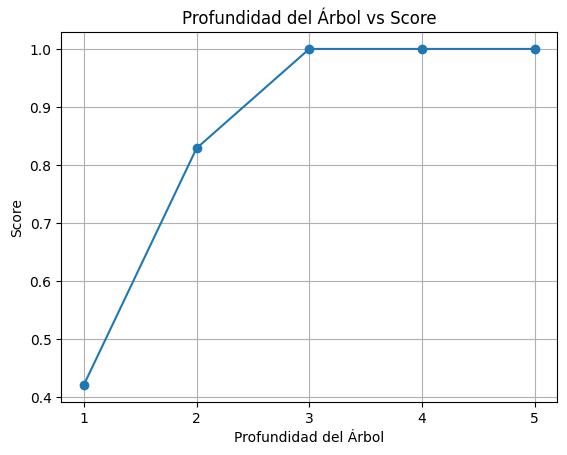

In [87]:
# lista que contiene 4 modelos de arbol de profundidad: indice + 1
trees = [DecisionTreeClassifier(criterion="entropy", max_depth=i+1) for i in range(5)]
# se entrenan los modelos
for tree in trees:
    tree.fit(X_train, y_train)
# score individual de cada modelo
scores = [accuracy_score(y_test, tree.predict(X_test)) for tree in trees]

#Graficamos el score individual (profundidad -> score)
depths = list(range(1,6))
plt.plot(depths, scores, marker='o')
plt.title('Profundidad del Árbol vs Score')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('Score')
plt.xticks(depths)
plt.grid(True)
plt.show()

3c. Para hacer k-folding utilizamos la librería de sklearn, dividimos el training data en 4 folds y para cada modelo promediamos el score obtenido entre los 4 folds. Similarmente al caso anterior, utilizando el cross validation score obtenemos que el modelo empieza a funcionar muy bien a partir de profundidades superiores a 3.

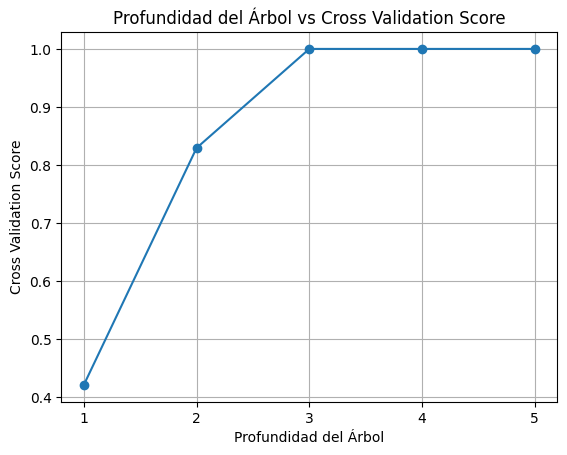

In [88]:
# lista que contiene el score de cada modelo segun cross validation
k_fold_scores = [cross_val_score(tree, X_train, y_train, cv=4) for tree in trees]
# se queda con la media del score de los folds
for i in range(len(k_fold_scores)):
    k_fold_scores[i] = sum(k_fold_scores[i])/len(k_fold_scores[i])

# graficamos el cross validation score (profundidad -> score)
plt.plot(depths, k_fold_scores, marker='o')
plt.title('Profundidad del Árbol vs Cross Validation Score')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('Cross Validation Score')
plt.xticks(depths)
plt.grid(True)
plt.show()

3d. De los dos scores sacados anteriormente podemos concluir que a partir de la profundidad 3 podriamos elegir nuestro mejor modelo, ya que desde ahí parece superar la etapa de underfitting, cabe aclarar que se han hecho pruebas con trees de mayor profundidad esperando el punto del underfitting, pero el score nunca bajo de forma significativa, asi que nos limitamos solamente hasta la profundidad 5. Para la evaluación multiclase contamos con una matriz de confusión, la cual para cada modelo nos dice cuantas imágenes clasificó bien y cuantas no, además de a cual grupo fueron erroneamente asignados, en este caso vocales. Con el modelo de profundidad 1 podemos ver que se confunden las señas para la "i" con las de "a" y "e" de forma equitativa, con el modelo de profundidad 2 observamos que se confunde a la letra "a" con la "e", y de ahí en adelante los modelos de mayor profundidad se comportan de forma óptima. Siguiendo el principio de siempre elegir la simpleza por sobre sobre todo, nos quedamos con un tree de profundidad 3 como nuestro mejor modelo para la predicción de vocales en lenguaje de señas.

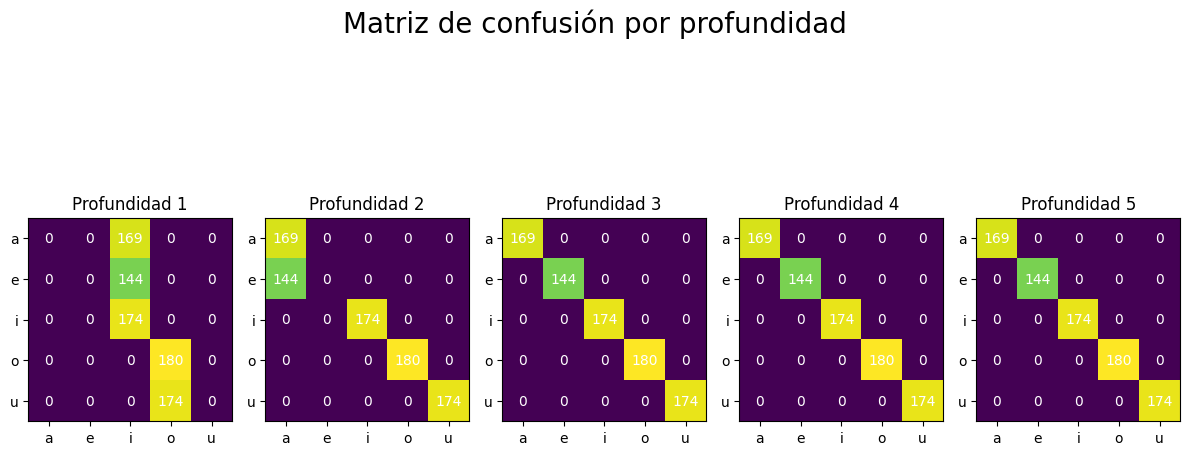

In [89]:
conf_mat = []
for tree in trees:
    #labels 0, 4, 8, 14, 20 corresponden a, e, i, o, u respectivamente
    conf_mat.append(confusion_matrix(y_test, tree.predict(X_test), labels=[0, 4, 8, 14, 20]))

#gráfico matrices de confusión
fig, axs = plt.subplots(1, 5, figsize=(12, 6))
fig.suptitle('Matriz de confusión por profundidad', fontsize=20)
for i in range(len(conf_mat)):
    axs[i].imshow(conf_mat[i])
    axs[i].set_title('Profundidad ' + str(i+1))
    axs[i].set_xticks([i for i in range(0, 5)], labels=['a', 'e', 'i', 'o', 'u'])
    axs[i].set_yticks([i for i in range(0, 5)], labels=['a', 'e', 'i', 'o', 'u'])
    for x in range(5):
        for y in range(5):
            axs[i].text(y, x, conf_mat[i][x, y], ha="center", va="center", color="w")
plt.tight_layout()
plt.show()